# Transforming Lapped Signal Vectors

[Nils Werner](https://www.audiolabs-erlangen.de/fau/assistant/werner) and [Bernd Edler](https://www.audiolabs-erlangen.de/fau/professor/edler)

[International Audio Laboratories Erlangen](https://www.audiolabs-erlangen.de/)

In [ ]:
import numpy as np
import scipy as sp
import scipy.signal as ss
import scipy.linalg
import skimage.util
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools

from utils import *

In the previous Notebook we briefly investigated lapped transforms by statically analysing their properties.

Crucially, we found a matrix that lets us investigate how two frames will interact when analyzed using MDCT.

In this Notebook we will see how we can use the introduced matrices to actually transform signals.

# Lapped Signal Vectors

The first step is to create a view of our data that can directly be transformed by our two-frame analysis matrix.

Because we are working with lapped transforms, this view needs to be lapped. In essence we are trying to implement

$$
\mathbf{X}_{n,k} = \vec{x}_{nN+k} \qquad k = 0, \dots, LN
$$

Where $N$ is the framelength and $L$ is the overlap factor (in this case $L=2$). This can efficiently be implemented by modifying the "stride of an array", and for NumPy two functions are available:

```python
skimage.util.view_as_windows()
```

and

```python
numpy.lib.stride_tricks.as_strided()
```

However for convenience we have created several utility functions `lap()`, `unlap()` and others. Please inspect `utils.py` for details.

First we will play around with our `lap()` and `unlap()` functions to get a feel for what they do.

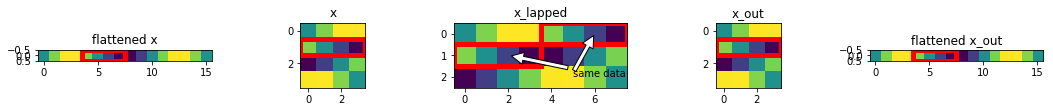

In [ ]:
N = 4
L = 2

# create input signal
x = np.sin(2 * np.pi * np.arange(16) / 44100 * 4400)

# cut signal into frames of length N
x = x.reshape(-1, N)

# create lapped view of x
x_lapped = lap(x, L)

# reconstruct framed signal from lapped view
x_out = unlap(x_lapped, L)

# Plot data
f, (a, b, c, d, e) = plt.subplots(1, 5, figsize=(18, 1.2))
a.imshow(x.ravel()[None, :])
a.set_title("flattened x")
b.imshow(x)
b.set_title("x")
c.imshow(x_lapped)
c.set_title("x_lapped")
d.imshow(x_out)
d.set_title("x_out")
e.imshow(x_out.ravel()[None, :])
e.set_title("flattened x_out")

a.add_patch(patches.Rectangle((3.5, -0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
b.add_patch(patches.Rectangle((-0.5, 0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
c.add_patch(patches.Rectangle((3.5, -0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
c.add_patch(patches.Rectangle((-0.5, 0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
d.add_patch(patches.Rectangle((-0.5, 0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
e.add_patch(patches.Rectangle((3.5, -0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))

c.annotate('same data', xy=(2, 1), xytext=(5, 2), color='black', arrowprops={'facecolor': 'white', 'shrink': 0.05})
c.annotate('', xy=(6, 0), xytext=(5, 1.8), arrowprops={'facecolor': 'white', 'shrink': 0.05})

None

We can clearly see the right part of each frame in `x_lapped` repeating in the left half of the following frame. In other words: this representation is lapped by exactly 50% (`L=2`).

If we were to modify any element in `x_lapped`, the corresponding element in the lapped neighbor would change, too:

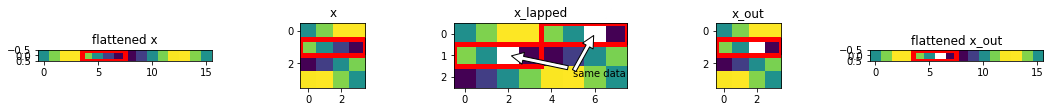

In [ ]:
N = 4
L = 2

# create input signal
x = np.sin(2 * np.pi * np.arange(16) / 44100 * 4400)

# cut signal into frames of length N
x = x.reshape(-1, N)

# create lapped view of x
x_lapped = lap(x, L)

x_lapped[0, 6] = np.nan

# reconstruct framed signal from lapped view
x_out = unlap(x_lapped, L)

# Plot data
f, (a, b, c, d, e) = plt.subplots(1, 5, figsize=(18, 1.2))
a.imshow(x.ravel()[None, :])
a.set_title("flattened x")
b.imshow(x)
b.set_title("x")
c.imshow(x_lapped)
c.set_title("x_lapped")
d.imshow(x_out)
d.set_title("x_out")
e.imshow(x_out.ravel()[None, :])
e.set_title("flattened x_out")

a.add_patch(patches.Rectangle((3.5, -0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
b.add_patch(patches.Rectangle((-0.5, 0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
c.add_patch(patches.Rectangle((3.5, -0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
c.add_patch(patches.Rectangle((-0.5, 0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
d.add_patch(patches.Rectangle((-0.5, 0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))
e.add_patch(patches.Rectangle((3.5, -0.5), 4, 1, linewidth=5, edgecolor='red', facecolor='none'))

c.annotate('same data', xy=(2, 1), xytext=(5, 2), color='black', arrowprops={'facecolor': 'white', 'shrink': 0.05})
c.annotate('', xy=(6, 0), xytext=(5, 1.8), arrowprops={'facecolor': 'white', 'shrink': 0.05})

None

# Lapped Transforms

In the previous Notebook, we derived how we can derive matrices that transform two frames at once. We will use those matrices here, so we will quickly recreate them.

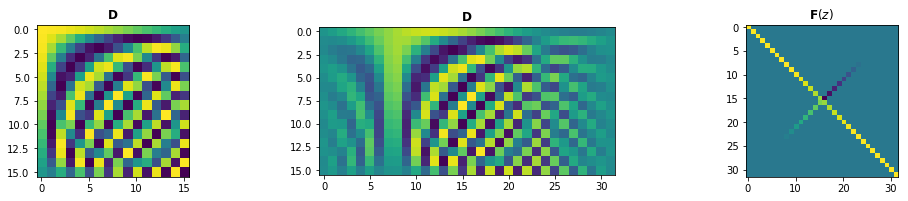

In [ ]:
fl = 16

D = dct4(fl)
M = mdct(fl) * ss.cosine(2 * fl)
tmp = D.T @ M
F = make_twoframe(tmp)

f, (a, b, c) = plt.subplots(1, 3, figsize=(18, 2.8))
a.imshow(D)
a.set_title("$\mathbf{D}$")
b.imshow(M)
b.set_title("$\mathbf{D}$")
c.imshow(F)
c.set_title("$\mathbf{F}(z)$")
None

As a test we will try to run the filterbank to analyse and synthesize the input signal, and compare the outputs. In $z$-Domain Polyphase Matrices [2], we would express our operation as

$$
\vec{x}_{\mathrm{out}}(z) = \mathbf{F}(z)^{-1} \; \mathbf{D}^{-1} \; \mathbf{D} \; \mathbf{F}(z) \; \vec{x}(z)
$$

Every polynomial matrix in this equation  ($\mathbf{F}(z)$) will be processing more than one frame, so we need to temporarily switch to a lapped memory view using `lap()`. Afterwards, we can remove the overlap again using `unlap()`.

Every real matrix in this equation ($\mathbf{D}$) will only be processing one frame at a time, so no lapping/unlapping is required.

In [ ]:
# create input signal
x = np.sin(2 * np.pi * np.arange(2 * fl * 128) / 44100 * 440)

# cut signal into frames
x = x.reshape(-1, fl)

# Time Domain Aliasing, requires lapped view
tmp = lap(x)
tmp = transform(tmp, F)
tmp = unlap(tmp)

# DCT-IV, requires single frame only
X = transform(tmp, D)
x_out = transform(X, D.T)

# Time Domain Aliasing Cancellation, requires lapped view
x_out = lap(x_out)
x_out = transform(x_out, F.T)
x_out = unlap(x_out)

np.allclose(x, x_out)

True

In the last line we can see that our transform perfectly reconstructs the input signal.

In essence, by overlapping our input signal and applying our folding matrix `F` on each overlapping frame, we have reproduced the transform that an infinitely long transform matrix would perform, without the massive amounts of unneccessary zeros in any of our matrices.

## Time-Varying Transforms

The most common variant of a time-varying MDCT is known as "**window switching**" [3]. To implement window switching in this framework, we can simply select the desired transform matrices `F` and `D` for each frame in `x`.

For framelengths of `fl_l` and `fl_s`, thee matrices then turn out to be

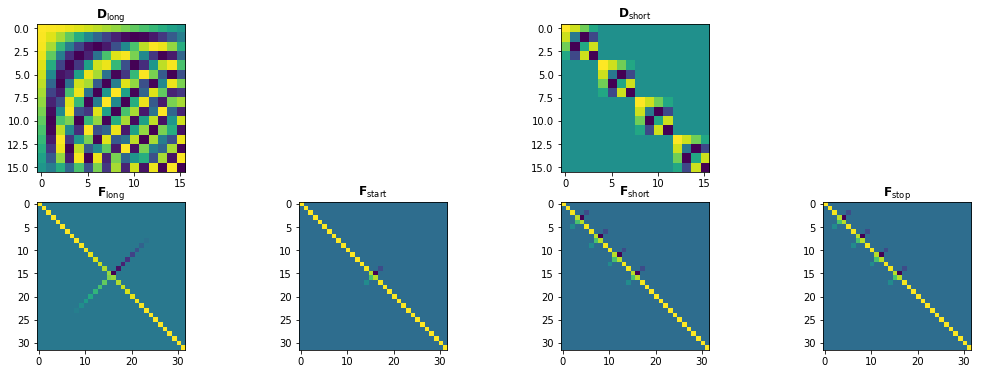

In [ ]:
fl_l = 16  # "long" framelength
fl_s = 4   # "short" framelength

D_l = dct4(fl_l)
M_l = mdct(fl_l) * ss.cosine(2 * fl_l)
tmp = D_l.T @ M_l
F_l = make_twoframe(tmp, trim=True)

D_s = dct4(fl_s)
M_s = mdct(fl_s) * ss.cosine(2 * fl_s)
tmp = D_s.T @ M_s
F_s = make_twoframe(tmp, trim=True)

D_long = D_l
D_short = scipy.linalg.block_diag(*[D_s] * (fl_l // fl_s))

F_long = scipy.linalg.block_diag(np.eye(fl_l // 2), F_l, np.eye(fl_l // 2))
F_start = scipy.linalg.block_diag(np.eye(fl_l - fl_s // 2), F_s, np.eye(fl_l - fl_s // 2))
F_short = scipy.linalg.block_diag(np.eye(fl_s // 2), *[F_s] * (fl_l // fl_s) , np.eye(fl_l - fl_s // 2))
F_stop = F_short

fig, ((a, b, c, d), (e, f, g, h)) = plt.subplots(2, 4, figsize=(18, 6))
a.imshow(D_long)
a.set_title("$\mathbf{D}_\mathrm{long}$")
b.set_visible(False)
c.imshow(D_short)
c.set_title("$\mathbf{D}_\mathrm{short}$")
d.set_visible(False)

e.imshow(F_long)
e.set_title("$\mathbf{F}_\mathrm{long}$")
f.imshow(F_start)
f.set_title("$\mathbf{F}_\mathrm{start}$")
g.imshow(F_short)
g.set_title("$\mathbf{F}_\mathrm{short}$")
h.imshow(F_stop)
h.set_title("$\mathbf{F}_\mathrm{stop}$")
None

Naturally, selecting the correct folding matrix in the correct situation is crucial, so the following rules need to be observed:

| Current $\mathbf{D}$ | Next $\mathbf{D}$ | $\rightarrow$ Current $\mathbf{F}$ |
|----------------------|-------------------|------------------------------------|
| long                 | long              | long                               |
| long                 | short             | start                              |
| short                | short             | short                              |
| short                | long              | stop                               |


# References

 1. Werner, Nils and Edler, Bernd, "[Experimenting with Lapped Transforms in Numerical Computation Libraries using Polyphase Matrices and Strided Memory Views](http://www.aes.org/e-lib/browse.cfm?elib=20381)". Audio Engineering Society Convention 146, 2019
 1. Schuller, G. D. T. and Smith, M. J. T., "[New framework for modulated perfect reconstruction filter banks](https://ieeexplore.ieee.org/document/533715)". IEEE Transactions on Signal Processing, 44(8), pp. 1941–1954, 1996, ISSN 1053-587X, doi:10.1109/78.533715.
 1. Edler, Bernd, "[Codierung von Audiosignalen mit überlappender Transformation und adaptiven Fensterfunktionen](https://www.degruyter.com/view/j/freq.1989.43.9/freq.1989.43.9.252/freq.1989.43.9.252.xml)", Frequenz, Bd. 43, S. 252–256, Sep. 1989.